In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
import os
import shutil
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder
import sys
sys.path.append('../scripts')
from autoencoder import TorchEncoder, TorchDecoder
import random
import torch
import torch.nn as nn
import seaborn as sns

if torch.cuda.is_available():
#     dev = "cuda:0"
    dev = "cpu"
else:
    dev = "cpu"
print(dev)

cpu


In [7]:
# Initialise
x_train = pd.read_csv('../output/dataset/census2/x_test.csv')
x1_name = 'age'
x2_name = 'hours_per_week'
tuner = 2

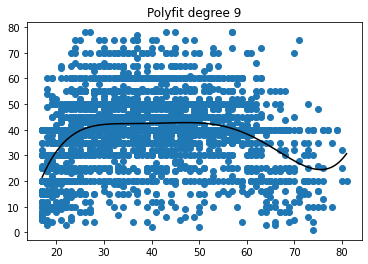

[ 1.37303357e-06 -3.33026773e-04  3.10966945e-02 -1.40867224e+00
  3.11476301e+01 -2.27768301e+02]


In [8]:
# Find Equation
X = x_train[x1_name]
y = x_train[x2_name]
X_seq = np.linspace(X.min(),X.max(),300).reshape(-1,1)
coefs = np.polyfit(X.values.flatten(), y.values.flatten(), 5)
plt.figure()
plt.plot(X_seq, np.polyval(coefs, X_seq), color="black")
plt.title("Polyfit degree "+str(9))
plt.scatter(X,y)
plt.show()
print(coefs)

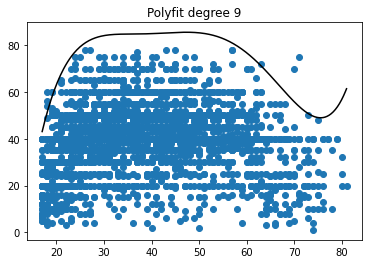

[84.82407658 84.82407658 85.49092708 ... 50.93956252 84.63891929
 84.82407658]


In [9]:
# Tune your equation
coefs_new = np.copy(coefs)
coefs_new *= tuner
plt.figure()
plt.plot(X_seq, np.polyval(coefs_new, X_seq), color="black")
plt.title("Polyfit degree "+str(9))
plt.scatter(X,y)
plt.show()
print(np.polyval(coefs_new, X))

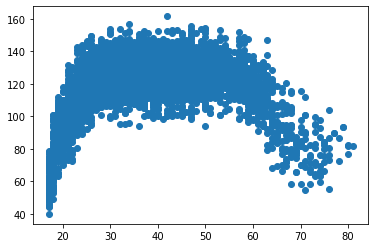

In [10]:
# Creating new x
# Getting std for specific x
def std(X_, x1, x_name=x1_name, y_name=x2_name):
    X__ = X_[X_[x_name] == x1]
    mu = np.mean(X__)
    sigma = np.std(X__)
    return mu[y_name], sigma[y_name]
y_new = []
for i in X:
    mu, sigma = std(x_train, i)
    noise = np.random.normal(mu, sigma, 1)[0]
    y_new.append(np.polyval(coefs_new, i) + noise)
plt.scatter(X,y_new)
plt.show()

In [6]:
# # Test Accuracy on Original vs Imputed
# model_name = 'autoencode'
# data_path = 'clf_autoencoder_2'
# my_file = "../output/model/census2/encoder_torch.joblib"
# clf = load(my_file)
# # print(x_train.head())
# x_new_1 = x_train.to_numpy()
# print(x_new_1.shape)
# print(clf.predict_proba(x_new_1))
# y_test_scores1 = clf.predict(x_new_1)
# unique1, counts1 = np.unique(y_test_scores1, return_counts=True)
# test1 = dict(zip(unique1, counts1))
# print("Test acc original: ", test1[0] / len(y_test_scores1))
# print(y_test_scores1, counts1)

# # Replace column with y_new
# y_new = np.array(y_new)
# x_train_anomalous = x_train.copy()
# x_train_anomalous[x2_name] = y_new
# # print(x_train.head())
# x_new_2 = x_train_anomalous.to_numpy()
# np.savetxt('age_hpw_anomaly.txt', x_new_2, fmt='%d')
# y_test_scores2 = clf.predict(x_new_2)
# print(clf.predict_proba(x_new_2))
# unique2, counts2 = np.unique(y_test_scores2, return_counts=True)
# test2 = dict(zip(unique2, counts2))
# print("Test acc new: ", test2[0] / len(y_test_scores2))
# print(y_test_scores2, counts2)

<class 'pandas.core.frame.DataFrame'>
Kinaan k tattey:  tensor([[40.9670, 56.1879, 11.4929,  ..., 76.0022, 38.8484, 44.0291],
        [40.9824, 56.1681, 12.0239,  ..., 76.0663, 39.0905, 43.5048],
        [41.4233, 56.2377, 11.4996,  ..., 76.0983, 39.6714, 44.4995],
        ...,
        [36.9198, 55.4251, 11.3703,  ..., -0.1430, 30.9194, 38.8333],
        [40.4690, 56.0920, 11.9024,  ..., 75.8985, 38.1669, 43.1038],
        [40.6838, 56.1480, 11.5562,  ..., 75.9384, 38.3772, 43.6717]],
       grad_fn=<LeakyReluBackward1>)
tensor([[3.5605e+01, 6.5955e-01, 2.2287e+00,  ..., 4.8616e-06, 2.2992e-02,
         1.6234e+01],
        [3.5789e+01, 6.1338e+01, 4.0961e+00,  ..., 4.4007e-03, 8.1813e-03,
         4.2187e+01],
        [1.2793e+01, 5.8109e-01, 2.2487e+00,  ..., 9.6683e-03, 4.5076e-01,
         2.0246e+01],
        ...,
        [3.5796e+02, 2.4804e+00, 4.0581e+01,  ..., 9.8787e+00, 1.4207e+02,
         1.3612e+00],
        [7.1724e+01, 8.2443e-01, 4.3998e+00,  ..., 1.0303e-02, 6.9401e-0

<AxesSubplot:>

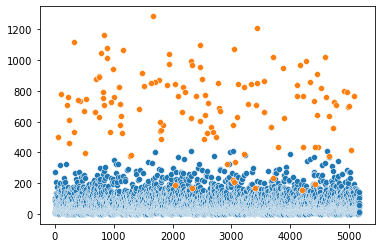

In [34]:
def pred(x, enc, dec):
    # x = x[1]
    y = enc(x)
    y = dec(y)
    loss_fn = nn.MSELoss(reduction='none')
    print("Kinaan k tattey: ",y)
    los_val = loss_fn(y, x)
    print(los_val)
    return torch.mean(los_val, dim=1).cpu().detach().numpy()


total_anomalies = 130
epoch = 1000
df_normal = pd.read_csv('../output/dataset//census2/x_test.csv')
model_path = '../output/model/census2/all_epochs_no_dropouts/'
encoder_model = model_path + 'ep_' + str(epoch) + '_encoder_model.pth'
decoder_model = model_path + 'ep_' + str(epoch) + '_decoder_model.pth'
anomaly_desciption = f'Feature hpw is regressed over feature age with tuner value ' + str(tuner) + '.'

y_new = np.array(y_new)
x_anomalous = df_normal.copy()
print(type(x_anomalous))
x_anomalous[x2_name] = y_new
x_anomalous = x_anomalous.sample(n=total_anomalies)
# print(x_train.head())
# x_new_2 = x_train_anomalous.to_numpy()
if True:
    dataset_path = '../output/anomaly_included/census/'
    anomaly_type = 'distance'
    anomaly_name = '_age_educationnum_education_sex/'
    anomaly_path = dataset_path + anomaly_type + anomaly_name
    os.makedirs(anomaly_path, exist_ok=True)
    with open(anomaly_path + 'readme.txt', 'w') as f:
        f.write(anomaly_desciption)

    # Train set
    shutil.copyfile('../output/dataset/census2/x_train.csv', anomaly_path + '/x_train.csv')

    # Antoine's set
    df_normal[:1000].to_csv(anomaly_path + 'x_test_antoine.csv')
    # Test set
    df_normal[1000:].to_csv(anomaly_path + 'x_test.csv')
    # Anomalies
    x_anomalous[:100].to_csv(anomaly_path + 'anoamlous_data.csv')
    # Anomalies Antoine
    x_anomalous[100:].to_csv(anomaly_path + 'anoamlous_data_antoine.csv')


# print(x_normal.shape)


x_anomalous = x_anomalous.to_numpy()
x_normal = df_normal.to_numpy()
encoder = TorchEncoder(in_dim=x_normal.shape[1]).to(dev)
decoder = TorchDecoder(out_dim=x_normal.shape[1]).to(dev)
encoder.load_state_dict(torch.load(encoder_model))
decoder.load_state_dict(torch.load(decoder_model))

# x_anomalous = df_anomalous.to_numpy()
# score_normal = model.predict_proba(x_normal)[:, 1]
# randomlist = random.sample(range(0, len(score_normal)), total_anoamlies)
# x_anomalous = x_anomalous.to_numpy()
# x_normal = df_normal.to_numpy()
# x_anomalous = df_anomalous.to_numpy()
score_normal = pred(torch.tensor(x_normal, dtype=torch.float).to(dev), encoder, decoder)
randomlist = random.sample(range(0, len(score_normal)), total_anomalies)
# x_anomalous = np.loadtxt('age_hpw_anomaly.txt', dtype=int)
score_anomalous = pred(torch.tensor(x_anomalous, dtype=torch.float).to(dev), encoder, decoder)
print(score_anomalous, score_normal)
sns.scatterplot(y=score_normal, x=list(range(len(score_normal))))
print(len(score_anomalous), len(randomlist))
sns.scatterplot(y=score_anomalous, x=randomlist)

In [36]:
model_path = '/home/saif/MyStuff/UdS/Thesis/Proposal/causal-shapley/output/model/census2/all_epochs_no_dropouts/'
encoder_model = model_path + 'ep_' + str(epoch) + '_encoder_model.pth'
decoder_model = model_path + 'ep_' + str(epoch) + '_decoder_model.pth'
for param in encoder.parameters():
  print(param.data)
x_temp = pd.read_csv('../output/anomaly_included/census/distance_sex_hpw_workclass/x_test.csv').to_numpy()
print(pred(torch.tensor([[44, 57, 15, 13, 11, 61, 74, 76, 39, 44]], dtype=torch.float).to(dev), encoder, decoder))
print(x_temp[0], encoder.training, decoder.training)

tensor([[-0.7516,  0.4018, -0.4206, -0.2858, -0.6003,  0.1528, -0.6521, -0.2714,
          0.9922, -0.2110],
        [ 0.0106, -0.1888,  0.3356,  0.0688,  0.1312,  0.5912,  0.6259,  0.3616,
          0.0921, -0.2765],
        [ 0.0965,  0.0033,  0.2628,  0.1342, -0.1548,  0.3713, -0.1811, -1.8002,
          0.2313,  0.1009],
        [ 0.2478,  0.2361, -0.1760, -0.1069, -0.1516,  0.0123, -0.1344,  0.1213,
          0.0391,  0.2614],
        [ 0.0744, -0.0215,  0.3201,  0.1484, -0.0134, -0.0175,  0.6588, -1.3369,
         -0.0124,  0.0205],
        [ 0.4175,  0.5988,  0.2257,  0.5666,  0.3395,  0.4893,  0.3799, -0.2137,
          0.3087,  0.2425],
        [ 0.8407, -0.0672,  0.3917,  0.0527,  0.0133,  0.0862, -0.1555, -0.2262,
          0.8230,  0.1745],
        [ 0.2559,  0.4888,  0.1704,  0.5783,  0.3412, -0.1590,  0.1426, -0.5203,
          0.2380,  0.1897]])
tensor([ 0.0810,  2.0120, -0.0166,  1.9040,  4.7190, -1.4016, -1.8605,  2.8304])
tensor([[ 0.1355, -0.2193,  0.2625, -0.5021, -

In [ ]:
df_an = pd.read_csv('anomalous.csv')
columns = df_an.columns
df_an_fn = df_an.loc[df_an[columns[1]] == 1.0]
print(df_an_fn)
print(df_an_fn[df_an_fn[columns[0]] == df_an_fn[columns[0]].min()])
df_an_fp = df_an.loc[df_an[columns[1]] == 0]
print(df_an_fp)
print(df_an_fp[df_an_fp[columns[0]] == df_an_fp[columns[0]].max()])